In [2]:
# !pip install --upgrade pip
# !pip install numpy --quiet
# !pip install matplotlib --quiet
# !pip install scipy --quiet


In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import scipy.integrate 


In [2]:
def cornell_potential(radii: list[float], alpha: float, beta: float) -> list[float]:
    return -(4/3)*alpha/radii + beta*radii

def wave_function(U0,r, n, l, alpha, beta, mu, E):
    u,v= U0
    a = l*(l+1)
    b = 2*mu*E
    c = 2*mu*alpha
    d = 2*mu*beta
    
    potential = cornell_potential(r, alpha, beta)
    
    return [v,(a/r**2)*u -2*mu*u*(E-potential)]

def square_wavefunction(wave_function: list[float]) -> list[float]:
    pdf = np.zeros(wave_function.shape)
    for i in range(len(wave_function)):
        pdf[i] = abs(wave_function[i])**2
    return pdf
def normalise_wavefunction(
        probability_density_function: list[float], 
        wave_function: list[float], 
        v: list[float], 
        radii: list[float]
    ) -> list[float]:
    
    norm = scipy.integrate.simpson(probability_density_function, radii)
    recprical_norm = 1/norm
    root_reciprical_norm = 1/np.sqrt(norm)
    probability_density_function = probability_density_function*recprical_norm
    wave_function = wave_function*root_reciprical_norm
    v = v *root_reciprical_norm
    
    return probability_density_function, wave_function, v


def count_nodes_and_turns(u,v,r):
    node_count = 0
    turn_count = 0
    for i in range(len(r) -1):
        cross_up = u[i] <= 0 and u[i+1] >= 0
        cross_down = u[i] >= 0 and u[i+1] <= 0
        
        turn_up = v[i] >= 0 and v[i+1] <= 0
        turn_down = v[i] <= 0 and v[i+1] >= 0
        
        if cross_up or cross_down:
            node_count += 1
        if turn_up or turn_down:
            turn_count +=1
            
    return node_count, turn_count

In [3]:
U0 = [0,1]
alpha = 0.4
beta = 0.195

charm_quark_mass = 1.27
charmonium_mass_1S = 2.9839
# charm_quark_mass = 1.34
# charmonium_mass_1S = 3.068

charmonium_energy_1S = charmonium_mass_1S - 2*charm_quark_mass
#mu = mc/2

recpricol_reduced_mass = 1/charm_quark_mass + 1/charm_quark_mass
reduced_mass = 1/recpricol_reduced_mass
r = np.linspace(0.0000001, 15, 10000)




0.21305281591834502


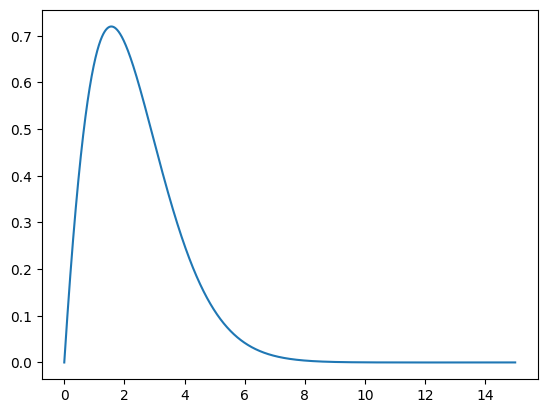

In [ ]:
def solve_quarkonium(u0, epsilon, step_size = 0.015, layer = 5):
    divergence_has_flipped = False
    steps_taken = 0
    while not divergence_has_flipped:
        epsilon_lower = epsilon + (step_size * steps_taken)
        sol = scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,epsilon_lower, reduced_mass, charmonium_energy_1S))
        v1 = sol[:,1]
        
        steps_taken += 1
        epsilon_upper = epsilon + (step_size * steps_taken)
        sol = scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,epsilon_upper, reduced_mass, charmonium_energy_1S))
        v2 = sol[:,1]
        divergence_has_flipped = (v1[-1] < 0) != (v2[-1] < 0)
        
    gamma = (epsilon_lower+epsilon_upper)/2

    if layer > 0:
        return solve_quarkonium(u0, epsilon = epsilon_lower, step_size=step_size/2, layer= layer -1)
    
    return gamma, scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,gamma, reduced_mass, charmonium_energy_1S))

    
    
beta, sol = solve_quarkonium(U0, epsilon=0.09, layer=30)
u = sol[:,0]

print(beta)
plt.plot(r, u)
plt.show()

0.21305281592532993


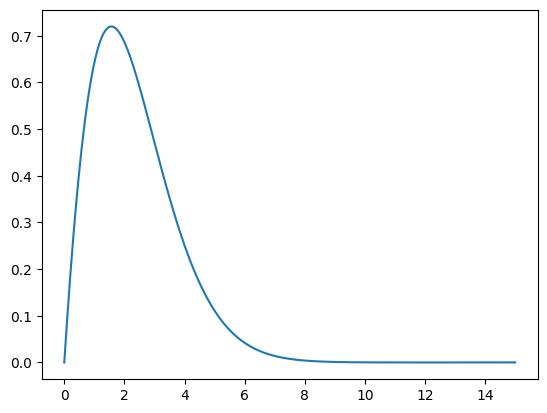

In [20]:
# epsilon lower is given aqnd not calculated as it avoids calculating all values twice
def solve_quarkonium_recursive(u0, epsilon_lower, fixed_value, step_size = 0.015, steps_taken = 0, layer = 5):
    epsilon_upper = epsilon_lower + step_size * (steps_taken+1)
    v_lower = scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,epsilon_lower, reduced_mass, fixed_value))[:,0]
    v_upper = scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,epsilon_upper, reduced_mass, fixed_value))[:,0]
    
    divergence_has_flipped = (v_lower[-1] < 0) != (v_upper[-1] < 0)
    if not divergence_has_flipped:
        return solve_quarkonium_recursive(u0, epsilon_upper, fixed_value, step_size= step_size, steps_taken= steps_taken+1, layer=layer)
    
    # print(layer)
    # Divergence has flipped
    if layer > 0:
        return solve_quarkonium_recursive(u0, epsilon_lower, fixed_value, step_size = step_size/2, steps_taken = 0, layer = layer - 1)
    
    # Divergence has flipped and all layers have been run
    gamma = (epsilon_lower+epsilon_upper)/2
    return gamma, scipy.integrate.odeint(wave_function, u0, r, args=(1,0,alpha,gamma, reduced_mass, fixed_value))


beta, sol = solve_quarkonium_recursive(U0, epsilon_lower=0.09, fixed_value= charmonium_energy_1S, layer=30)
u = sol[:,0]

print(beta)
plt.plot(r, u)
plt.show()

    


This is not the final method used to create the write up in this repo, but is given to demonsatrate the type of code written for the project.